## QSVT Search   (Credit : github.com/bartubisgin)

In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *


C:\Users\Shaurya\anaconda3\envs\QiskitEnv\lib\site-packages\requests_ntlm\requests_ntlm.py:5: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography import x509


In [2]:
system_qubits = 2 
#following the argument above we need 2 additional qubits
nqubits = system_qubits + 2
q = QuantumRegister(nqubits, 'q')
circuit = QuantumCircuit(q)  


#### Transform : P(A)-> 1   (T_d chebyshev)

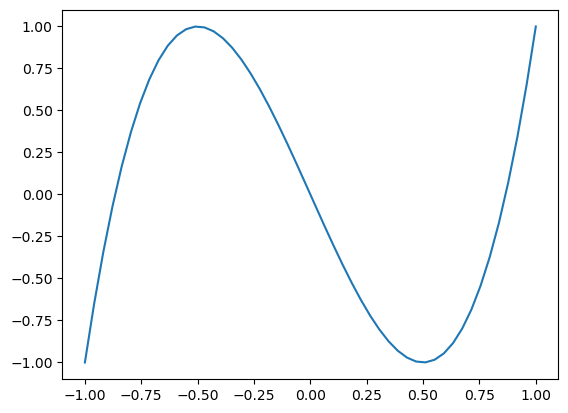

In [4]:
x = np.linspace(-1, 1)
test = np.polynomial.Chebyshev((0, 0, 0, 1)) # The 3rd Chebyshev polynomial!
y = test(x)
plt.plot(x, y)


In [3]:
# Define projectors.
# Note that p_left is actually p_right from above because the order
# of operations are reversed when equations are turned into circuits
# due to how time-flow is defined in circuit structures

# In the Qiskit implementation qubit indexes start from 0
# and the most significant qubit is the highest index
# keeping this in mind e.g for 4 nqubits = {q0,q1,q2,q3}
# q0 and q1 are the system qubits
# q2 is the signal qubit
# q3 is the ancillary rotation qubit
# nqubits-1 = 4-1 = 3 below, then corresponds to q3

def p_left(q, phi): #right projector
    qc = QuantumCircuit(q)
    n = q
    ctrl_range = list(range(0,n-1))
    
    for qubit in range(n-1): # Implement a simple multi 0-controlled
        qc.x(qubit)
    qc.mcx(ctrl_range , n-1) # 0-Controlled on all but the last qubits, acts on the last qubit
    for qubit in range(n-1):
        qc.x(qubit)
        
    #qc.barrier(0, 1, 2, 3)
    qc.rz(phi, n-1) # RZ(phi) on the last qubit
    #qc.barrier(0, 1, 2, 3)
    
    for qubit in range(n-1): # Reverse the effect of the first multi-control
        qc.x(qubit)
    qc.mcx(ctrl_range ,n-1) 
    for qubit in range(n-1):
        qc.x(qubit)
    
    p_left_gate = qc.to_gate() # Compiles all this into a gate
    p_left_gate.name = "P"
    return p_left_gate

def p_right(phi): # Left projector acts just on the signal and the ancillary qubit
    qc = QuantumCircuit(2)
    
    qc.cx(0, 1)
    qc.rz(phi, 1)
    qc.cx(0 ,1)
    
    p_right_gate = qc.to_gate()
    p_right_gate.name = "R(Φ)"
    return p_right_gate


In [13]:
def U(q): 
    qc = QuantumCircuit(q)
    n = q + 1
    
    for qubit in range(n-2):
        qc.h(qubit)
    
    qc.mcx(list(range(0,n-2)), n-2)
    
    U_gate = qc.to_gate()
    U_gate.name = "W"
    return U_gate

def reverse_gate(gate):
    gate_rev = gate.reverse_ops()
    gate_rev.name = gate.name + "$^†$"
    return gate_rev


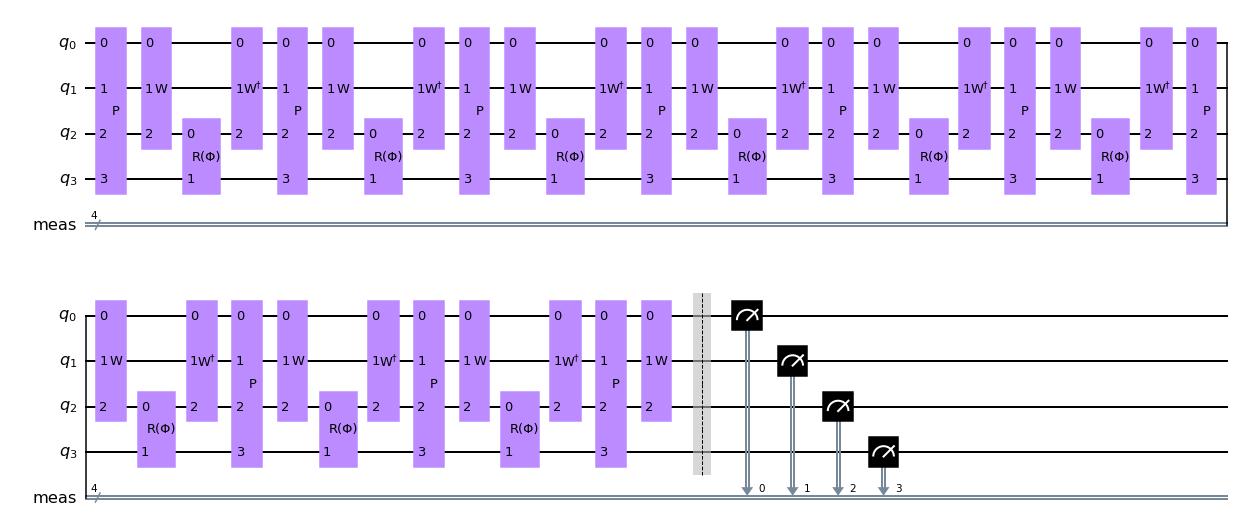

In [16]:
#we have 2 system qubits
system_qubits = 2 
#following the argument above we need 2 additional qubits
nqubits = system_qubits + 2
q = QuantumRegister(nqubits, 'q')
circuit = QuantumCircuit(q)

d = 19

u = U(nqubits-1)
u_dag = reverse_gate(u) #construct U_dagger

p_right_range = [nqubits-2, nqubits-1] # build the ranges of qubits for gates to act upon
u_range = list(range(0, nqubits-1))
p_left_range = list(range(0, nqubits))

circuit.append(p_left(nqubits, (1-d)*pi), p_left_range) # in general, starting from this line, 
circuit.append(u, u_range)                              # the circuit would iterate over the phases,
                                                        # but the phases for pure Cheby are just trivial pi/2
                                                        # so we chose to directly putting pi's in here for simplification
for i in range((d-1)//2):                               # we put pi instead of pi/2 because of how RZ is defined in Qiskit
    circuit.append(p_right(pi), p_right_range) 
    circuit.append(u_dag, u_range)
    circuit.append(p_left(nqubits, pi), p_left_range)
    circuit.append(u, u_range)

circuit.measure_all()
circuit.draw('mpl')


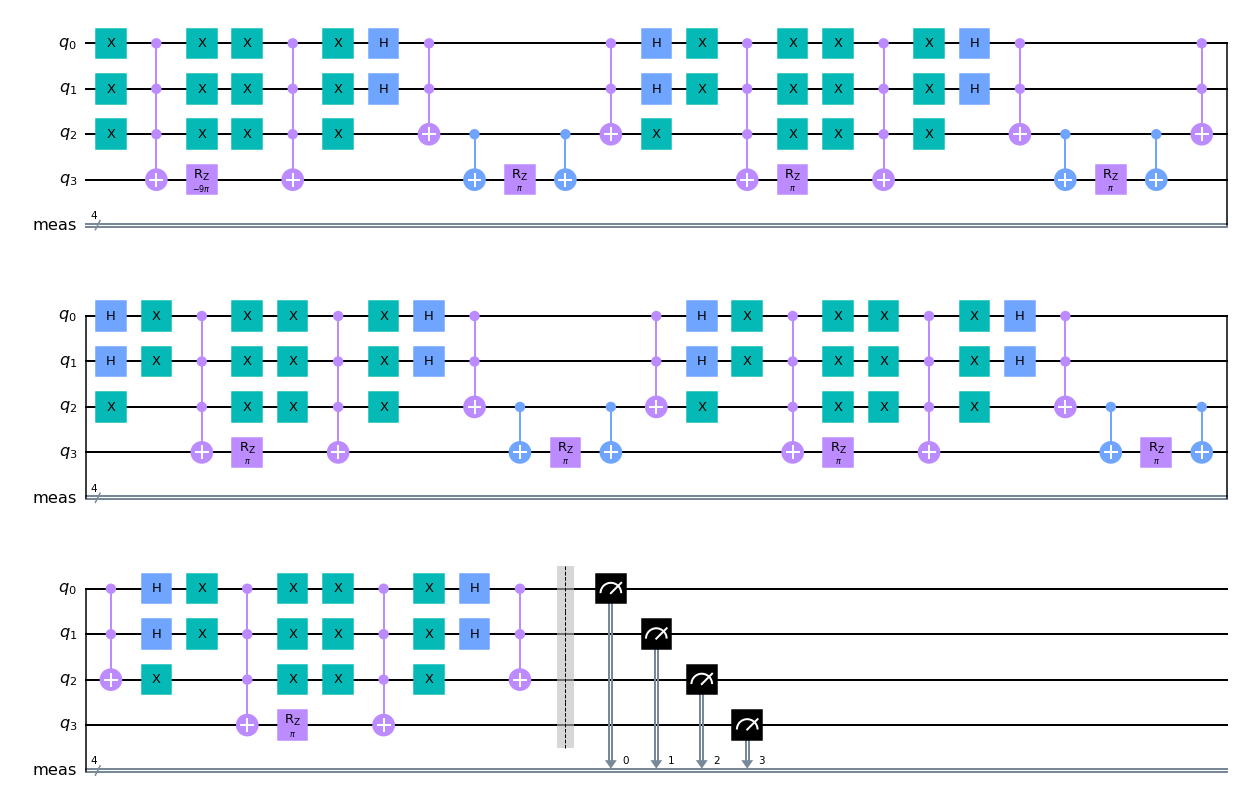

In [9]:
circuit.decompose().draw('mpl')